### Transfer Learning with Tensorflow : Scaling up

In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import os 
import pathlib 
import random
import matplotlib.image as mpimg
import zipfile
import wget
import tensorflow_hub as hub

### Get Helper Functions

In [12]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"


response = requests.get(url)
code = response.text

exec(code)

In [13]:
train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

In [14]:
class_names=os.listdir("101_food_classes_10_percent/train/")
print(class_names,len(class_names))

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

Image shape: (384, 512, 3)


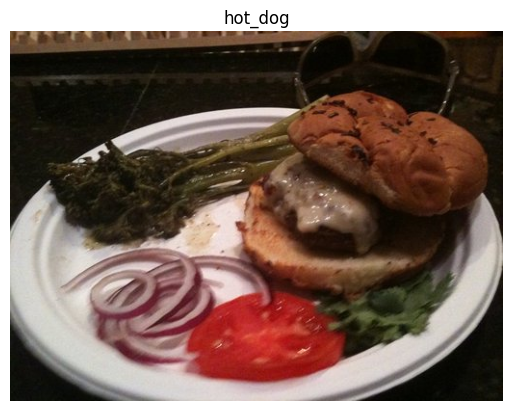

In [15]:
view_random_image(train_dir,class_names[55])

In [16]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_all_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                            image_size=IMG_SIZE,label_mode="categorical",batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
image_size=IMG_SIZE,
label_mode="categorical",
batch_size=BATCH_SIZE)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big  model with transfer learning on 10% of 101 food classes

Steps for Goal:
* Create a  ModelCheckPoint Callback
* Create a Data augmentation layer 
* Build a headless (no top layers) Functional EffecientNetB0 backboned-model (we'll create our own output layer)
* Compile model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time) 

In [18]:
# Create checkpoint callback 
checkpoint_path='101_classes_10_percent_data_model_checkpoint'
checkpoint_callback=checkpoint_callback_fun(checkpoint_path,monitor="val_accuracy",save_weights_only=True,save_best_only=True)


In [26]:
# Create data augmentaion layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Setup data augmentation 

data_augmentation=Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
],name="data_augmentation")

In [27]:
# Setup the base model and freeze its layers

base_model =tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable=False

# Setup model archeticture with trainable top layers

inputs=layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)

model=tf.keras.Model(inputs,outputs)




In [28]:
model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [29]:
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_all_10_percent),
        validation_data=test_data,
        validation_steps=int(0.15*len(test_data)),
        callbacks=[
           checkpoint_callback]
         )

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.4730 - accuracy: 0.2514
Epoch 1: val_accuracy improved from -inf to 0.43273, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 151s 585ms/step - loss: 3.4730 - accuracy: 0.2514 - val_loss: 2.4775 - val_accuracy: 0.4327
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.3542 - accuracy: 0.4661
Epoch 2: val_accuracy improved from 0.43273 to 0.50371, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 83s 349ms/step - loss: 2.3542 - accuracy: 0.4661 - val_loss: 2.0473 - val_accuracy: 0.5037
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.9679 - accuracy: 0.5300
Epoch 3: val_accuracy improved from 0.50371 to 0.52383, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 77s 324ms/step - loss: 1.9679 - accuracy: 0.5300 - val_